# ETL Pipeline for US Immigration and Demographics Data
### Data Engineering Capstone Project

#### Project Summary
This project will build an ETL pipeline to prepare data for an analytics table with US immigration and demographics. The table can be used for analysis of immigration to US and answer queries such as which ports do immigrants arrive the most and what states get the most immigrants.

The project follows these steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

In [2]:
# create a Spark Session
spark = SparkSession.builder.\
    config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11").\
    enableHiveSupport().getOrCreate()

### Step 1: Scope the Project and Gather Data

#### Scope 

In this project, we will be using the US Immigration data to build a data pipeline for an analytics table. This data comes from the US National Tourism and Trade Office. Additionally, we will be using the US City Demographics data from OpenSoft. For ETL pipeline, we will use Apache Spark to extract and clean the data and load it into tables for our Data Scientist to perform any machine learning algorithms.

#### Describe and Gather Data 
Now that we have a good understanding of the project, lets read the data into a Pandas dataframe and take a look at the first few rows.

##### Immigration Data 

In [3]:
# Read immigration data for April
immigration_file = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
immigration_df = pd.read_sas(immigration_file, 'sas7bdat', encoding="ISO-8859-1")

In [4]:
# Show first 5 rows of data
immigration_df.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,NaN,NaN,...,U,NaN,1979.0,10282016,NaN,NaN,NaN,1.897628e+09,NaN,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,NaN,1991.0,D/S,M,NaN,NaN,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,NaN,M,1961.0,09302016,M,NaN,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,1988.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,2012.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2


In [5]:
# Count number of rows
immigration_df.cicid.count()

3096313

##### Demographics Data 

In [6]:
# Read US demographics data
demographics_file = "us-cities-demographics.csv"
demographics_df = pd.read_csv(demographics_file, sep=';')

In [7]:
# Show first 5 rows of demographics data
demographics_df.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


### Step 2: Explore and Assess the Data
#### Explore the Data 
Now we will explore the data for any missing values and perform cleaning steps.

#### Cleaning Steps
1. Check percentage of missing values for each dataframe
2. Drop columns with a high percentage of missing values
3. Drop rows with missing values (if needed)

##### Clean Immigration Data

In [8]:
# Percentage of missing values for immigration data
immigration_df.isna().mean() * 100

cicid        0.000000
i94yr        0.000000
i94mon       0.000000
i94cit       0.000000
i94res       0.000000
i94port      0.000000
arrdate      0.000000
i94mode      0.007719
i94addr      4.921079
depdate      4.600859
i94bir       0.025902
i94visa      0.000000
count        0.000000
dtadfile     0.000032
visapost    60.757746
occup       99.737559
entdepa      0.007687
entdepd      4.470769
entdepu     99.987340
matflag      4.470769
biryear      0.025902
dtaddto      0.015405
gender      13.379429
insnum      96.327632
airline      2.700857
admnum       0.000000
fltno        0.631364
visatype     0.000000
dtype: float64

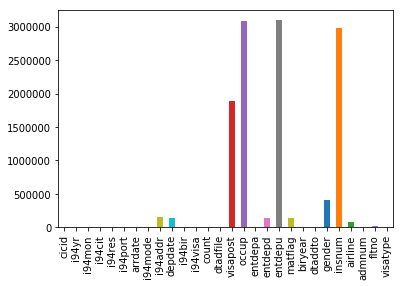

In [9]:
# Visualizing missing values for immigration data
immigration_df.isna().sum().plot(kind='bar')
plt.show()

In [10]:
# Remove columns with more than 60% missing values
cols_with_missing = ['visapost', 'occup', 'entdepu', 'insnum']
immigration_df = immigration_df.drop(columns=cols_with_missing)

In [11]:
# Check percentage of missing values for immigration data after cleanup
immigration_df.isna().mean() * 100

cicid        0.000000
i94yr        0.000000
i94mon       0.000000
i94cit       0.000000
i94res       0.000000
i94port      0.000000
arrdate      0.000000
i94mode      0.007719
i94addr      4.921079
depdate      4.600859
i94bir       0.025902
i94visa      0.000000
count        0.000000
dtadfile     0.000032
entdepa      0.007687
entdepd      4.470769
matflag      4.470769
biryear      0.025902
dtaddto      0.015405
gender      13.379429
airline      2.700857
admnum       0.000000
fltno        0.631364
visatype     0.000000
dtype: float64

Now our immigration data is much cleaner than before. There are still missing values, however deleting the rows might not be a good solution at this point. We can leave this to our Data Scientist to decide what approach to take with the missing values.

##### Clean Demographics Data

In [12]:
# Percentage of missing values for demographics data
demographics_df.isna().mean() * 100

City                      0.000000
State                     0.000000
Median Age                0.000000
Male Population           0.103770
Female Population         0.103770
Total Population          0.000000
Number of Veterans        0.449671
Foreign-born              0.449671
Average Household Size    0.553442
State Code                0.000000
Race                      0.000000
Count                     0.000000
dtype: float64

Since there is a small percentage of rows missing in the demographics data, we can drop rows with missing values as it will not affect the results.

In [13]:
# Remove rows with missing values for demographics data
demographics_df = demographics_df.dropna()

In [14]:
# Count number of missing values for demographics data
demographics_df.isna().sum()

City                      0
State                     0
Median Age                0
Male Population           0
Female Population         0
Total Population          0
Number of Veterans        0
Foreign-born              0
Average Household Size    0
State Code                0
Race                      0
Count                     0
dtype: int64

We have successfully cleaned the demographics data.

### Step 3: Define the Data Model


#### 3.1 Conceptual Data Model

![](schema.png)

The model consists of immigration and demographics tables. The tables are joined with state code columns so that further data can be extracted from the demographics table. This would allow analysis into immigration patterns and which states do immigrants settle the most as well as population information.

The immigration table can itself be used to answer queries such as which ports do immigrants enter the most and which mode of arrival (land, sea, air) is the most used. We can also obtain trends based on month to see if immigration increases during certain times of the year. Columns containing missing values and those that were not required for the analysis have been dropped.

#### 3.2 Mapping Out Data Pipelines

Below are the steps for the data pipeline:

1. Extract the demographics data into a dataframe
2. Drop any null values
3. Write data to the demographics table and partition by state code
4. Extract the immigration data
5. Select only columns that are required for our analysis
6. Write data to the immigration table, partition and join by state code
7. Run data quality checks

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
We will now build the data pipeline to create the data model.

In [15]:
# Get demographics data
demographics_file = "us-cities-demographics.csv"
demographics_df = spark.read.csv(demographics_file, header=True, inferSchema=True, sep=';')

In [16]:
# extract columns to create demographics table
demographics_table = demographics_df.select(
    col('City').alias('city'),
    col('State').alias('state'),
    col('Median Age').alias('median_age'),
    col('Male Population').alias('male_population'),
    col('Female Population').alias('female_population'),
    col('Total Population').alias('total_population'),
    col('Number of Veterans').alias('num_of_veterans'),
    col('Foreign-born').alias('foreign_born'),
    col('Average Household Size').alias('avg_household_size'),
    col('State Code').alias('state_code'),
    col('Race').alias('race'),
    col('Count').alias('count')
).dropna()

# write demographics table to parquet files partitioned by state_code
demographics_table.write.partitionBy('state_code').parquet("output/demographics.parquet", mode="overwrite")

In [17]:
# Get immigration data
immigration_file = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
immigration_df = spark.read.format('com.github.saurfang.sas.spark').load(immigration_file)

In [18]:
# extract columns to create immigration table
immigration_table = immigration_df.select(
    col('i94yr'),
    col('i94mon'),
    col('i94port'),
    col('arrdate'),
    col('i94mode'),
    col('i94addr').alias('state_code'),
    col('depdate'),
    col('i94bir'),
    col('dtadfile'),
    col('biryear'),
    col('dtaddto'),
    col('gender'),
    col('airline'),
    col('visatype')
).join(demographics_table, on="state_code")

# write immigration table to parquet files partitioned by state_code
immigration_table.write.partitionBy('state_code').parquet("output/immigration.parquet", mode="overwrite")

#### 4.2 Data Quality Checks
We will now run a data quality check in order to validate that the tables were created successfully and get the number of records copied to the tables.

In [19]:
def quality_check(df, desc):
    """
    Checks for data quality
    
    Parameters:
        df: spark dataframe
        desc: dataframe description
    
    Output:
        prints result of data quality check
    """
    
    record_count = df.count()
    if record_count == 0:
        print("Data quality check failed for {} table with zero records.".format(desc))
    else:
        print("Data quality check passed for {} table with {} records.".format(desc, record_count))

# Run data quality check
quality_check(immigration_table, "immigration")
quality_check(demographics_table, "demographics")

Data quality check passed for immigration table with 3096313 records.
Data quality check passed for demographics table with 2875 records.


#### 4.3 Data dictionary 

##### Immigration Table Data Dictionary

![](imm_dictionary.png)

##### Demographics Table Data Dictionary

![](demographics_dictionary.png)

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
    - Pandas was used to explore the dataset and find out any missing or null values. Since the data size was quite significant, Apache Spark was used to create the ETL pipeline because of its ability to handle big data.
* Propose how often the data should be updated and why.
    - The I-94 immigration data has a monthly subscription, therefore it is recommended to update the data monthly to get access to the latest data.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
     - If there is a significant increase in data, we could use a cloud data warehouse and increase the nodes in our cluster to process the large amount of data.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
     - We can use a scheduling tool such as Apache Airflow to run the ETL pipeline and update the data overnight if data is needed to be updated daily.
 * The database needed to be accessed by 100+ people.
     - We can use Amazon Redshift in case the database is needed to be accessed by a lot of people.